In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

import functions.data_wrangling as dw
import functions.eddy_feedback as ef 

In [31]:
path_dir = '/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded'

# extract model names
files = os.listdir(path_dir)
models = [os.path.basename(f).split('_')[0] for f in files]
models.sort()

models.remove('CESM1-WACCM-SC')
models.remove('E3SMv1')

# Create dictionary containing each model name and dataset
pamip_datasets = {}
djf_pamip = {}
for model in models:
    # create file path by joining directory and model name
    file_path = os.path.join(path_dir, f'{model}_*.nc')
    # open xarray dataset
    ds = xr.open_mfdataset(file_path, parallel=True, chunks={'time':31})
    # Add dataset to dictionary with required model name
    pamip_datasets[model] = ds
    
    djf = dw.seasonal_mean(ds, season='djf')
    djf_pamip[model] = djf#.mean('time')

In [32]:
# Initialize an empty list to store the results
results = []

# Loop through each model and calculate EFP values
for model in models:
    ds = pamip_datasets[model]
    efp_nh = ef.calculate_efp(ds, data_type='pamip')
    efp_sh = ef.calculate_efp(ds, data_type='pamip', calc_south_hemis=True)
    results.append({'Model': model, 'EFP NH': efp_nh, 'EFP SH': efp_sh})

# Create a DataFrame from the results
efp = pd.DataFrame(results)

# Print the DataFrame
efp

,Model,EFP NH,EFP SH
0,CESM2,0.3693,0.3419
1,CNRM-CM6-1,0.2421,0.2082
2,CanESM5,0.4256,0.4618
3,EC-EARTH3,0.2945,0.3135
4,ECHAM6.3,0.0139,0.0103
5,FGOALS-f3-L,0.2354,0.1274
6,HadGEM3-GC31-LL,0.2730,0.2951
7,HadGEM3-GC31-MM,0.3137,0.3002
8,IPSL-CM6A-LR,0.2719,0.1959
9,MIROC6,0.2213,0.3253


In [33]:
# Initialize an empty list to store the results
results_djf = []

# Loop through each model and calculate EFP values
for model in models:
    djf = djf_pamip[model]
    efp_nh = ef.calculate_efp(djf, data_type='pamip')
    efp_sh = ef.calculate_efp(djf, data_type='pamip', take_level_mean=None)
    results_djf.append({'Model': model, 'EFP': efp_nh, 'EFP (500hPa)': efp_sh, 'difference': efp_nh - efp_sh})

# Create a DataFrame from the results
efp = pd.DataFrame(results_djf)

# Print the DataFrame
efp

,Model,EFP,EFP (500hPa),difference
0,CESM2,0.3693,0.3420,0.0273
1,CNRM-CM6-1,0.2421,0.2338,0.0083
2,CanESM5,0.4256,0.4382,-0.0126
3,EC-EARTH3,0.2945,0.2717,0.0228
4,ECHAM6.3,0.0139,0.0135,0.0004
5,FGOALS-f3-L,0.2354,0.1805,0.0549
6,HadGEM3-GC31-LL,0.2730,0.2240,0.0490
7,HadGEM3-GC31-MM,0.3137,0.2931,0.0206
8,IPSL-CM6A-LR,0.2719,0.2515,0.0204
9,MIROC6,0.2213,0.2536,-0.0323


In [34]:
def bootstrap_resampling_pamip(ds, num_samples=1000):
    """
    Perform bootstrap resampling over 'time' dimension of the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset to resample.
    num_samples (int): The number of bootstrap samples to generate.

    Returns:
    list: A list of resampled datasets.
    """
    
    # ds = ds.mean('time')
    
    if 'ens_ax' in ds.dims:
        bootstrap_indices = np.random.choice(ds.sizes["ens_ax"], size=(num_samples, ds.sizes["ens_ax"]), replace=True)
        bootstrap_dssets = [ds.isel(ens_ax=idx) for idx in bootstrap_indices]
    else:
        bootstrap_indices = np.random.choice(ds.sizes["time"], size=(num_samples, ds.sizes["time"]), replace=True)
        bootstrap_dssets = [ds.isel(time=idx) for idx in bootstrap_indices]
    return bootstrap_dssets

In [35]:
djf_pamip

{'CESM2': <xarray.Dataset>
 Dimensions:  (time: 1, ens_ax: 100, level: 19, lat: 192)
 Coordinates:
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
   * time     (time) object 2000-12-01 00:00:00
 Dimensions without coordinates: ens_ax
 Data variables:
     ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>
     epfy     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>
     divFy    (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>,
 'CNRM-CM6-1': <xarray.Dataset>
 Dimensions:  (time: 1, ens_ax: 300, level: 23, lat: 128)
 Coordinates:
   * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 3.0 2.0 1.0 0.4
     lon      float64 ...
   * time     (time) date

In [36]:
# Specify the models you want to extract
selected_models = ['CESM2', 'CNRM-CM6-1']

# Create a new dictionary with only the selected models
selected_djf_pamip = {model: djf_pamip[model] for model in selected_models}

# Print the new dictionary to verify
selected_djf_pamip

{'CESM2': <xarray.Dataset>
 Dimensions:  (time: 1, ens_ax: 100, level: 19, lat: 192)
 Coordinates:
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * level    (level) float64 1e+03 925.0 850.0 700.0 600.0 ... 20.0 10.0 5.0 1.0
   * time     (time) object 2000-12-01 00:00:00
 Dimensions without coordinates: ens_ax
 Data variables:
     ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>
     epfy     (time, ens_ax, level, lat) float32 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>
     divFy    (time, ens_ax, level, lat) float64 dask.array<chunksize=(1, 100, 19, 192), meta=np.ndarray>,
 'CNRM-CM6-1': <xarray.Dataset>
 Dimensions:  (time: 1, ens_ax: 300, level: 23, lat: 128)
 Coordinates:
   * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * level    (level) float32 1e+03 925.0 850.0 700.0 600.0 ... 3.0 2.0 1.0 0.4
     lon      float64 ...
   * time     (time) date

In [37]:
# Initialize a dictionary to store the bootstrap results for each model
bootstrap_results = {}

# Loop through each model in djf_pamip
# for model, ds in djf_pamip.items():
for model, ds in selected_djf_pamip.items():
    print(model)
    # Perform bootstrap resampling
    bootstrap_djfsets = bootstrap_resampling_pamip(ds)
    
    # Initialize a list to store the EFP values for each bootstrap sample
    efp_values = []
    
    # Loop through each bootstrap sample and calculate EFP values
    for item in bootstrap_djfsets:
        efp = ef.calculate_efp(item, data_type='pamip')
        efp_values.append(efp)
    
    # Store the EFP values in the dictionary
    bootstrap_results[model] = efp_values

# # Print the bootstrap results for each model
# for model, values in bootstrap_results.items():
#     print(f"Model: {model}, Bootstrap EFP Values: {values[:5]}...")  # Print first 5 values for brevity

CESM2
CNRM-CM6-1


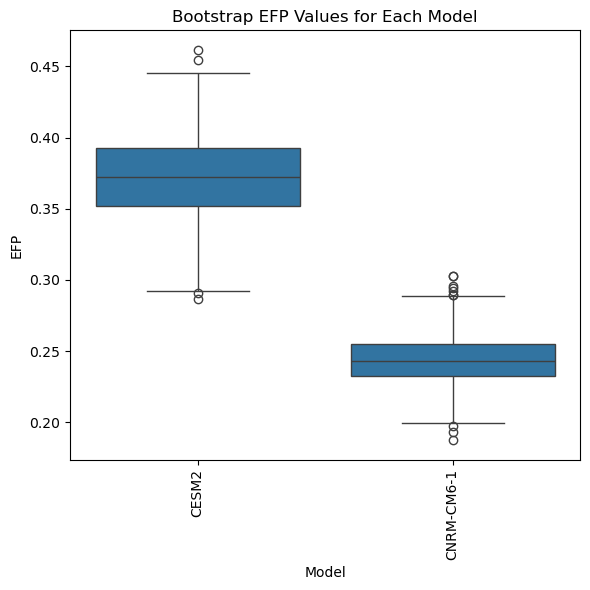

In [40]:
# Convert bootstrap results to a DataFrame for plotting
bootstrap_df = pd.DataFrame({
    'Model': np.repeat(list(bootstrap_results.keys()), [len(v) for v in bootstrap_results.values()]),
    'EFP': np.concatenate(list(bootstrap_results.values()))
})

# Plot the bootstrap results as box plots using Seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Model', y='EFP', data=bootstrap_df)
plt.xticks(rotation=90)
plt.title('Bootstrap EFP Values for Each Model')
plt.xlabel('Model')
plt.ylabel('EFP')
plt.tight_layout()

# Save the plot
plt.show()